In [1]:
from FESTIM.generic_simulation import run

Create an empty parameters dictionnary

In [2]:
parameters = {}

Create the materials. In this demo, our domain will be a tungsten sandwich with a copper interlayer.
`"borders"` represents the boundaries of the 1D domain in $\text{m}$.
`"E_D"` is the energy barrier for diffusion expressed in $\text{eV}$.
`"D_0"` is the pre-exponential factor of the Arhenius' law for the diffusion coefficient expressed in $\text{m}^{2}\text{s}^{-1}$.
Diffusion coefficient is expressed as:
\begin{equation}
    D(T) = D_{0} e^{\frac{-E_{diff}}{k_B \cdot T}}
\end{equation}

where $T$ is the temperature in $\text{K}$ and $k_B = 8.6\times 10 ^{-5} \: \text{eV/K}$ the Boltzmann constant.

Finally, `"id"` is the id of the material subdomain. This will be needed later on.

In [3]:
tungsten_left = {
    "borders": [0, 0.5e-7],
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 1
}
copper = {
    "borders": [0.5e-7, 1e-7],
    "E_D": 0.15,
    "D_0": 1.5e-7,
    "id": 2
}
tungsten_right = {
    "borders": [1e-7, 1.5e-7],
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 3
}
parameters["materials"] = [tungsten_left, copper, tungsten_right]

Now it's time to create a mesh for our simulation. One way of creating a 1D mesh in FESTIM is to directly provide the mesh coordinates (vertices). In this case, we want 200 nodes in the left hand side sub-domain, 100 nodes in the middle one and finally 200 cells in right hand side sub-domain.

In [4]:
import numpy as np

vertices = np.unique(np.concatenate(
        [np.linspace(0, 0.5e-7, num=200),
        np.linspace(0.5e-7, 1e-7, num=100),
        np.linspace(1e-7, 1.5e-7, num=200)]))

parameters["mesh_parameters"] = {
    "vertices": vertices
}

In FESTIM, each trap is defined by a dictionary with the following keys:

`"k_0"` and `"E_k"` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`"p_0"` and `"E_p"` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`"materials"` is a list of the materials' ids where the trap is.

For this example, there will be one trap in the tungsten parts (`trap_tunsgten`) and a trap in the copper layer (`trap_copper`).

In [5]:
tungsten_density = 6.3e28
trap_tungsten = {
    "k_0": 3.8e-17,
    "E_k": 0.39,
    "p_0": 8.4e12,
    "E_p": 1.2,
    "density": 1.3e-3*tungsten_density,
    "materials": [1, 3]
}

copper_density = 8.43e28
trap_copper = {
    "k_0": 6e-17,
    "E_k": 0.39,
    "p_0": 8e13,
    "E_p": 0.9,
    "density": 5e-5*copper_density,
    "materials": [2]
}
parameters["traps"] = [trap_tungsten, trap_copper]

The temperature in this example will be $320 \text{K}$ in the whole domain.

In [6]:
parameters["temperature"] = {
    "type": "expression",
    "value": 320,
}

[PUT SOME TEXT HERE]

In [7]:
boundary_conditions = [
            {
                "surfaces": [1],
                "value": 1e20,
                "type": "dc"
            },
            {
                "surfaces": [2],
                "type": "recomb",
                "Kr_0": 2.9e-10,
                "E_Kr": 1,
                "order": 2,
            }
    ]

parameters["boundary_conditions"] = boundary_conditions

All the output files will be exported in a directory named **outputs**.
The two types of derived quantities we are interested in are **volume integrations** of the solute and trapped concentrations as well as the computation of **fluxes on surfaces**.

In [8]:
folder = 'outputs'

exports = {
    "derived_quantities": {
        "folder": folder,
        "file": "derived_quantities.csv",
        "total_volume": [
            {
                "field": "solute",
                "volumes": [1, 2, 3]
            },
            {
                "field": 1,
                "volumes": [1, 3]
            },
            {
                "field": 2,
                "volumes": [2]
            }
        ],
        "surface_flux": [
            {
                "field": "solute",
                "surfaces": [1, 2]
            }
        ]
    },
    "txt": {
        "functions": ['1', '2', 'solute', 'retention'],
        "labels": ['1', '2', 'solute', 'retention'],
        "times": [2000, 17000, 20000],
        "folder": folder,
    },
}

parameters["exports"] = exports

The simulation will last $17 000$s.  

In [9]:
solving_parameters = {
    "final_time": 20000,
    "initial_stepsize": 50,
    "adaptive_stepsize": {
        "stepsize_change_ratio": 1.1,
        "dt_min": 1e-5
    },
    "newton_solver": {
        "absolute_tolerance": 1e10,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },
    "traps_element_type": "DG"
}

parameters["solving_parameters"] = solving_parameters

**Let's run the simulation!**

In [10]:
output = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...
s0.0 %        20000.0 s    Ellapsed time so far: 1.0 s


We can now plot the derived quantities computed with FESTIM

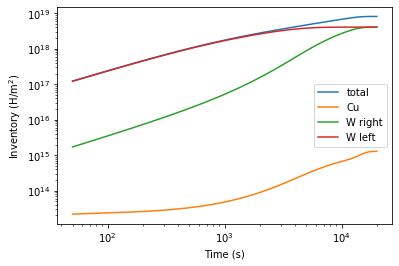

In [11]:
import matplotlib.pyplot as plt

derived_quantities = np.array(output["derived_quantities"][1:])
t = derived_quantities[:, 0]
retention = derived_quantities[:, -1] + derived_quantities[:, -2] + derived_quantities[:, -3]
plt.plot(t, retention, label="total")
plt.plot(t, derived_quantities[:, -1], label="Cu")
plt.plot(t, derived_quantities[:, -2], label="W right")
plt.plot(t, derived_quantities[:, -3], label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")
plt.show()

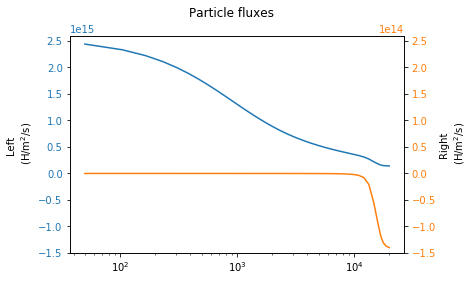

In [12]:
flux_left = derived_quantities[:, 1]
flux_right = derived_quantities[:, 2]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1.5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-1.5e14, 2.6e14)

plt.show()

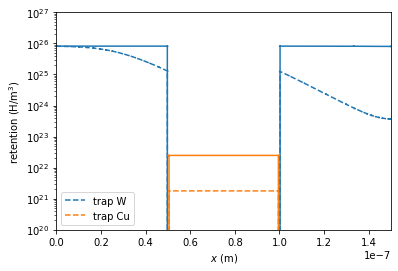

In [13]:
trap_W_1 = np.genfromtxt(folder + '/1_2000.0s.txt')
trap_W_2 = np.genfromtxt(folder + '/1_17000.0s.txt')
trap_cu_1 = np.genfromtxt(folder + '/2_2000.0s.txt')
trap_cu_2 = np.genfromtxt(folder + '/2_17000.0s.txt')

plt.xlim(0, 1.5e-7)
plt.ylim(bottom=1e20, top=1e27)
plt.plot(trap_W_1[:, 0], trap_W_1[:, 1], label="trap W", color="tab:blue", linestyle='--')
plt.plot(trap_cu_1[:, 0], trap_cu_1[:, 1], label="trap Cu", color="tab:orange", linestyle='--')
plt.plot(trap_W_2[:, 0], trap_W_2[:, 1], color="tab:blue")
plt.plot(trap_cu_2[:, 0], trap_cu_2[:, 1], color="tab:orange")
plt.legend()
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("retention (H/m$^3$)")
plt.show()

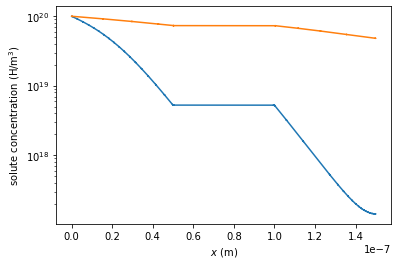

In [14]:
solute_1 = np.genfromtxt(folder + '/solute_2000.0s.txt')
solute_2 = np.genfromtxt(folder + '/solute_17000.0s.txt')

plt.plot(solute_1[:, 0], solute_1[:, 1])
plt.plot(solute_2[:, 0], solute_2[:, 1])
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.show()


Note how the solute concentration is continuous across interfaces.

A more relevant interface model includes conservation of chemical potential across the interfaces.
This can be done with FESTIM by simply providing the **solubility** parameters for the materials.

More details can be found in [Delaporte-Mathurin _et al_ (Nuclear Fusion, 2021)](https://iopscience.iop.org/article/10.1088/1741-4326/abd95f).

In [15]:
parameters["materials"][0]["S_0"] = 1.87e24
parameters["materials"][0]["E_S"] = 1.04
parameters["materials"][1]["S_0"] = 3.14e24
parameters["materials"][1]["E_S"] = 0.57
parameters["materials"][2]["S_0"] = 1.87e24
parameters["materials"][2]["E_S"] = 1.04

# tolerance is increased for better convergence
parameters["solving_parameters"]["newton_solver"]["absolute_tolerance"] = 1e12

output2 = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...
s0.0 %        20000.0 s    Ellapsed time so far: 5.7 s


**Let's see how the outputs are impacted !**

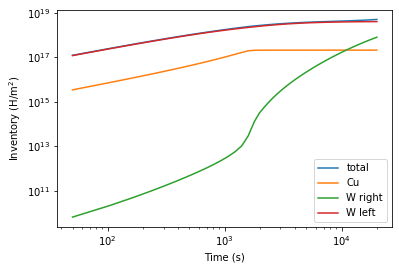

In [16]:
derived_quantities2 = np.array(output2["derived_quantities"][1:])
t = derived_quantities2[:, 0]
retention = derived_quantities2[:, -1] + derived_quantities2[:, -2] + derived_quantities2[:, -3]
plt.plot(t, retention, label="total")
plt.plot(t, derived_quantities2[:, -1], label="Cu")
plt.plot(t, derived_quantities2[:, -2], label="W right")
plt.plot(t, derived_quantities2[:, -3], label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")
plt.show()

When plotting the solute particles concentration profiles, one can now observe the **concentration jumps** at interfaces induced by the difference in solubilities.

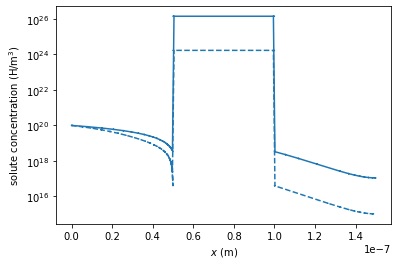

In [17]:
solute_1_chemical_potential = np.genfromtxt(folder + '/solute_2000.0s.txt')
solute_2_chemical_potential = np.genfromtxt(folder + '/solute_17000.0s.txt')

plt.plot(solute_1_chemical_potential[:, 0], solute_1_chemical_potential[:, 1], linestyle="--")
plt.plot(solute_2_chemical_potential[:, 0], solute_2_chemical_potential[:, 1], color="tab:blue")
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.show()

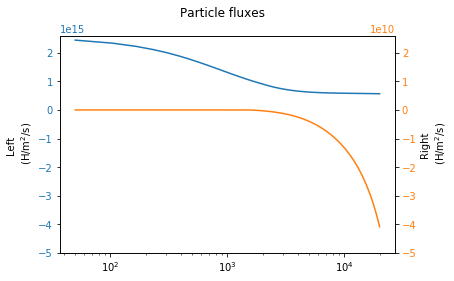

In [18]:
flux_left = derived_quantities2[:, 1]
flux_right = derived_quantities2[:, 2]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-5e10, 2.6e10)
plt.show()